In [1]:
## TODO remove uneccessary 
import datetime
import glob
import os
import statistics
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import pymannkendall
import eofs.xarray
import sklearn.cluster
import sklearn.metrics

import regionmask

import jsmetrics
from global_land_mask import globe

## load jet stat data

In [2]:
ALL_CODES = ['no outbreak', 'E', 'C', 'W', 'CE', 'WC', 'WE', 'WCE']

In [3]:
one_jet_stat = "Zappa et al. 2018"

In [4]:
NPac_path = '../data/jet_stream/jet-latitude-era5-standard-region-runs/*Pac.csv'# use your path
NAtl_path = '../data/jet_stream/jet-latitude-era5-standard-region-runs/*NAtl.csv'# use your path
NAm_path = '../data/jet_stream/jet-latitude-era5-standard-region-runs/*NAm.csv'# use your path
onejetlat_path = f'../data/jet_stream/jet-latitude-era5-standard-region-runs/{one_jet_stat}*.csv'# use your path
onejetspeed_path = f'../data/jet_stream/jet-speed-era5-standard-region-runs/{one_jet_stat}*.csv'# use your pa

In [5]:
NPac_files = glob.glob(os.path.join(NPac_path))
NAtl_files = glob.glob(os.path.join(NAtl_path))
NAm_files = glob.glob(os.path.join(NAm_path))
onejetlat_files = glob.glob(os.path.join(onejetlat_path))
onejetspd_files = glob.glob(os.path.join(onejetspeed_path))

In [6]:
def read_in_data_to_df(filepaths, region_col=True):
    file_ls = []
    for filename in filepaths:
        df = pd.read_csv(filename, index_col='time', header=0)
        metric_name = filename.split('/')[-1].split('Standard')[0].strip()
        region_name = filename.split('Standard')[1].split('.csv')[0].strip()
        if region_col:
            col_name = region_name
        else:
            col_name = metric_name
        df.columns = [col_name]
        file_ls.append(df)
    all_df = pd.concat(file_ls, axis=1, ignore_index=False)
    return all_df

In [7]:
all_jetlat_df = read_in_data_to_df(onejetlat_files)
all_jetlat_df = all_jetlat_df[["NPac", "NAm", "NAtl"]]

In [8]:
all_jetspd_df = read_in_data_to_df(onejetspd_files)
all_jetspd_df = all_jetspd_df[["NPac", "NAm", "NAtl"]]

In [9]:
npac_df = read_in_data_to_df(NPac_files, region_col=False)
nam_df = read_in_data_to_df(NAm_files, region_col=False)
natl_df = read_in_data_to_df(NAtl_files, region_col=False)

In [10]:
all_jetlat_df = all_jetlat_df["1950":]
all_jetspd_df = all_jetspd_df["1950":]

In [11]:
all_jetlat_df.index = pd.to_datetime(all_jetlat_df.index)
djf_jetlat_df = all_jetlat_df[all_jetlat_df.index.month.isin([12, 1, 2])]

In [12]:
all_jetspd_df.index = pd.to_datetime(all_jetspd_df.index)
djf_jetspd_df = all_jetspd_df[all_jetspd_df.index.month.isin([12, 1, 2])]

In [13]:
all_jetlat_df.head()

,NPac,NAm,NAtl
time,,,
1950-01-01,38.746817,50.256510,53.214878
1950-01-02,40.242403,48.409350,55.125693
1950-01-03,48.143827,46.086131,53.095374
1950-01-04,45.193884,42.247687,52.901151
1950-01-05,41.386229,45.269153,49.172188


# load extreme ('persistent') cold data

In [14]:
extreme_cold_persist_thresh = xr.open_dataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/input_preparation/outputs/ar6_3daypersist_extreme_cold_detrend_95thpercthresh_q01.nc')

# get k06 anom

In [15]:
k06 = xr.open_mfdataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_*100to400*.nc') # before: 

In [16]:
KOCH_WS_MONTH_MEAN = k06['weighted_average_ws'].groupby('time.month').mean('time')

In [17]:
def get_month_anom(row):
    row_month_anom = row - KOCH_WS_MONTH_MEAN.sel(month=row.time.dt.month)
    return row_month_anom


In [18]:
%%time
if os.path.exists('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc'):
    print('loading norm data')
    k06['jet_events_ws_norm'] = xr.open_dataarray('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc')
else:
    print('making norm data')
    k06['jet_events_ws_norm'] = k06['weighted_average_ws'].groupby('time').apply(get_month_anom)
    k06['jet_events_ws_norm'].to_netcdf('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc')

loading norm data
CPU times: user 5.62 ms, sys: 3.98 ms, total: 9.6 ms
Wall time: 11.1 ms


# Load climate indices

In [19]:
ao_index = pd.read_csv('../data/climate_indices/norm.daily.ao.cdas.z1000.19500101_current.csv')
ao_index['time'] = pd.to_datetime(ao_index[['year', 'month', 'day']])
ao_index = ao_index.set_index('time')
ao_index = ao_index.drop(['year', 'month', 'day'], axis=1)

In [20]:
nao_index = pd.read_csv('../data/climate_indices/norm.daily.nao.cdas.z500.19500101_current.csv')
nao_index['time'] = pd.to_datetime(nao_index[['year', 'month', 'day']])
nao_index = nao_index.set_index('time')
nao_index = nao_index.drop(['year', 'month', 'day'], axis=1)

In [21]:
pna_index = pd.read_csv('../data/climate_indices/norm.daily.pna.cdas.z500.19500101_current.csv')
pna_index['time'] = pd.to_datetime(pna_index[['year', 'month', 'day']])
pna_index = pna_index.set_index('time')
pna_index = pna_index.drop(['year', 'month', 'day'], axis=1)

In [22]:
enso = pd.read_csv('../data/climate_indices/oni.tsv', delimiter='\t', skipfooter=9)
enso = enso[' 1950         2024'].apply(lambda row: row.split('  ')).apply(pd.Series)
enso.columns = ['year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
enso = pd.melt(enso, id_vars=["year"], var_name="Date", value_name="ENSO")
enso['time'] = pd.to_datetime(enso['Date'] + enso['year'])
enso = enso.drop(columns=['year', 'Date'])
enso = enso.set_index('time')
enso = enso.astype(float)

/tmp/ipykernel_25436/1669365782.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  enso = pd.read_csv('../data/climate_indices/oni.tsv', delimiter='\t', skipfooter=9)
/tmp/ipykernel_25436/1669365782.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  enso['time'] = pd.to_datetime(enso['Date'] + enso['year'])


In [23]:
wpo_index = pd.read_csv('../data/climate_indices/wpo.reanalysis.t10trunc.1948-present.csv',delim_whitespace=True, header=None)
wpo_index.columns = ['year', 'month', 'day', 'WPO']
wpo_index['time'] = pd.to_datetime(wpo_index[['year', 'month', 'day']])
wpo_index = wpo_index.set_index('time')
wpo_index = wpo_index.drop(['year', 'month', 'day'], axis=1)

/tmp/ipykernel_25436/294705654.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  wpo_index = pd.read_csv('../data/climate_indices/wpo.reanalysis.t10trunc.1948-present.csv',delim_whitespace=True, header=None)


In [24]:
wpo_index[r'WPO ($\times10^{-3}$)'] = wpo_index['WPO'] / 100

In [25]:
clim_indices = pd.concat([ao_index, nao_index, pna_index, wpo_index, enso], axis=1)

In [26]:
clim_indices['ENSO'] = clim_indices['ENSO'].interpolate()

In [27]:
clim_indices = clim_indices.rename(columns={'ao_index_cdas': 'AO',\
                             'nao_index_cdas': 'NAO',\
                             'pna_index_cdas': 'PNA'})

In [28]:
clim_indices.mean() - clim_indices.std()

AO                       -1.542188
NAO                      -0.789364
PNA                      -0.798501
WPO                     -85.236542
WPO ($\times10^{-3}$)    -0.852365
ENSO                     -0.802808
dtype: float64

In [29]:
pmn_below_1sd = clim_indices['PNA'] < (clim_indices.mean()['PNA'] - clim_indices.std()['PNA'])

In [30]:
dates_below_1sd = pmn_below_1sd.where(lambda row: row).dropna().index

# Make plot

In [31]:
djf_cao_names = extreme_cold_persist_thresh['cold_air_event_stacked_names'].sel(time=extreme_cold_persist_thresh.time.dt.month.isin([12, 1, 2]))

In [32]:
djf_cao_names = djf_cao_names.astype(str)

In [33]:
npac_df_djf = npac_df
nam_df_djf = nam_df
natl_df_djf = natl_df

In [34]:
cao_code_names = {'000':'no outbreak', '001':'E', '011':'CE', '010':'C', '110':'WC', '100':'W', '101':'WE', '111':'WCE'}

In [35]:
npac_df_djf['coldairevent'] = djf_cao_names.to_dataframe()['cold_air_event_stacked_names'].apply(lambda row: cao_code_names[row])
nam_df_djf['coldairevent'] = djf_cao_names.to_dataframe()['cold_air_event_stacked_names'].apply(lambda row: cao_code_names[row])
natl_df_djf['coldairevent'] = djf_cao_names.to_dataframe()['cold_air_event_stacked_names'].apply(lambda row: cao_code_names[row])

In [36]:
djf_jetlat_df['coldairevent'] = djf_cao_names.to_dataframe()['cold_air_event_stacked_names'].apply(lambda row: cao_code_names[row])
djf_jetspd_df['coldairevent'] = djf_cao_names.to_dataframe()['cold_air_event_stacked_names'].apply(lambda row: cao_code_names[row])

djf_jetlat_df = djf_jetlat_df.join(clim_indices)
djf_jetspd_df = djf_jetspd_df.join(clim_indices)

/tmp/ipykernel_25436/1695150967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  djf_jetlat_df['coldairevent'] = djf_cao_names.to_dataframe()['cold_air_event_stacked_names'].apply(lambda row: cao_code_names[row])
/tmp/ipykernel_25436/1695150967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  djf_jetspd_df['coldairevent'] = djf_cao_names.to_dataframe()['cold_air_event_stacked_names'].apply(lambda row: cao_code_names[row])


In [37]:
djf_jetlat_df_melt = djf_jetlat_df.melt(id_vars=['coldairevent', 'NAO', 'PNA', 'ENSO'], value_vars=['NPac', 'NAm', 'NAtl'],
                 var_name='Region', value_name='Latitude')

djf_jetspd_df_melt = djf_jetspd_df.melt(id_vars=['coldairevent', 'NAO', 'PNA', 'ENSO'], value_vars=['NPac', 'NAm', 'NAtl'],
                 var_name='Region', value_name='Latitude')


In [38]:
ALL_CODES

['no outbreak', 'E', 'C', 'W', 'CE', 'WC', 'WE', 'WCE']

In [40]:
## DJF only 010 is not different
## MAM only 110 is not different
## JJA only 001 different
## SON all different


one_code = djf_jetlat_df.loc[djf_jetlat_df['coldairevent'] == 'no outbreak']['NPac'].dropna()
for code in ALL_CODES:
    another_code = djf_jetlat_df.loc[djf_jetlat_df['coldairevent'] == code]['NPac'].dropna()
    print('000', code, scipy.stats.ttest_ind(one_code,another_code, equal_var=False))
        

000 no outbreak TtestResult(statistic=0.0, pvalue=1.0, df=11636.0)
000 E TtestResult(statistic=6.304884551846185, pvalue=9.602727964839953e-10, df=318.85293550872126)
000 C TtestResult(statistic=1.9553206727184556, pvalue=0.052086804229950164, df=180.77517601299064)
000 W TtestResult(statistic=-2.419543235468019, pvalue=0.016434584810070294, df=199.99294797550968)
000 CE TtestResult(statistic=4.993618850877791, pvalue=6.295247456553927e-06, df=55.190415862535794)
000 WC TtestResult(statistic=4.044932626947715, pvalue=9.544050455148688e-05, df=114.23350934059954)
000 WE TtestResult(statistic=nan, pvalue=nan, df=nan)
000 WCE TtestResult(statistic=3.660525162486724, pvalue=0.007990811039921367, df=7.036980938477493)


/tmp/ipykernel_25436/3917703782.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print('000', code, scipy.stats.ttest_ind(one_code,another_code, equal_var=False))


In [41]:
djf_onlyoneevent_oceanjetlat = djf_jetlat_df_melt.loc[~(djf_jetlat_df_melt['Region'] == 'NAm') &\
                      (djf_jetlat_df_melt['coldairevent'].isin(['no outbreak', 'E',\
                                                              'C', 'W']))]

In [42]:
djf_onlyoneevent_oceanjetspeed = djf_jetspd_df_melt.loc[~(djf_jetspd_df_melt['Region'] == 'NAm') &\
                      (djf_jetspd_df_melt['coldairevent'].isin(['no outbreak', 'E',\
                                                              'C', 'W']))]

In [43]:
djf_indices_melt = djf_jetlat_df.reset_index().melt(id_vars=['coldairevent'], value_vars=['NAO', 'PNA', 'ENSO'],
                 var_name='Indices', value_name='Value')

In [44]:
djf_indices_melt_oneevent = djf_indices_melt.loc[djf_indices_melt['coldairevent'].isin(['no outbreak', 'E',\
                                                              'C', 'W'])]


In [45]:
sns.color_palette("Set2", 7)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)]

In [46]:
color_pallete_to_use = ['#D3D3D3']
color_pallete_to_use.extend(sns.color_palette("Set2", 7)[1:5])
color_pallete_to_use.extend(sns.color_palette("Set2", 7)[0:1])
color_pallete_to_use.extend(sns.color_palette("Set2", 7)[6:7])

In [47]:
color_pallete_to_use

['#D3D3D3',
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)]

In [48]:
NUM_DAYS_BREAK = 1

def cluster_datetimes(dates):
    clusters = []
    current_cluster = [dates[0].data]
    
    for i in range(1, len(dates)):
        if pd.to_timedelta(int(dates[i] - dates[i - 1])).days > NUM_DAYS_BREAK:
            # Start a new cluster
            clusters.append(current_cluster)
            current_cluster = [dates[i].data]
        else:
            # Add to the current cluster
            current_cluster.append(dates[i].data)
    
    # Add the last cluster
    clusters.append(current_cluster)
    
    return clusters


def cluster_count(data, season='annual'):
    clustered_count = {}
    if season != 'annual':
        data = data.sel(time=data.time.dt.season.isin([season]))
    for event_code in np.unique(data['cold_air_event_stacked_names'].data):
        onetype_coldair_event = data.where((data['cold_air_event_stacked_names'] == event_code)\
                                                    ).dropna(dim='time')
        clustered_count[cao_code_names[event_code]] = len(cluster_datetimes(onetype_coldair_event.time))
    return clustered_count

In [49]:
%%time
clustered_count_djf = cluster_count(extreme_cold_persist_thresh.sel(time=slice("1950", "2023-03")), season='DJF')

CPU times: user 21.3 s, sys: 439 ms, total: 21.8 s
Wall time: 21.8 s


### EOF

In [50]:
def create_data_flat_for_jetcode(coldairevent_code_to_lookat,  var_to_use='weighted_average_ws', n_clusters=4, lon_range=slice(120, 230), lat_range=slice(20, 70)):
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code_to_lookat)\
                                            ).dropna(dim='time')
    onetype_coldair_event = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))
    cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event.time)
    k06_my_persist = k06.sel(time=onetype_coldair_event.time.data)
    # with weighting
    for ind, dt_cluster in enumerate(cold_air_event_dateclusters):
        if ind == 0:
            k06_my_persist_weighted = k06_my_persist.sel(time=dt_cluster).mean('time')
        else:
            k06_my_persist_weighted = xr.concat([k06_my_persist_weighted, k06_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
    k06_my_persist_mean_weighted = k06_my_persist_weighted.mean('time')
    k06_my_persist['jet_events_ws_norm'].load()
    k06_my_persist = k06_my_persist.sel(lat=lat_range, lon=lon_range)
    data_flat = k06_my_persist[var_to_use].stack(spatial=('lat', 'lon')).values  # Shape (time, spatial)
    
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(data_flat)
    return kmeans, data_flat, k06_my_persist


In [51]:
var_to_use = 'jet_events_ws_norm'
n_clusters = 4
lon_range=slice(120, 240)
lat_range=slice(15, 70)

In [52]:
%%time
kmeans_001, data_flat_001, k06_my_persist_001 = create_data_flat_for_jetcode(coldairevent_code_to_lookat='001', var_to_use=var_to_use, n_clusters=n_clusters, lon_range=lon_range, lat_range=lat_range)


CPU times: user 2.81 s, sys: 335 ms, total: 3.15 s
Wall time: 2.38 s


In [53]:
coslat = np.cos(np.deg2rad(k06_my_persist_001.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

In [54]:
k06_all_DJF = k06.sel(lon=slice(120, 240), lat=slice(15, 70)).sel(time=k06.time.dt.season.isin(['DJF']))

In [55]:
print('select 1950-2023')
k06_all_DJF = k06_all_DJF.sel(time=slice("1950", "2023"))

select 1950-2023


In [56]:
%%time
jet_eof_all = eofs.xarray.Eof(k06_all_DJF[var_to_use], weights=wgts)


CPU times: user 23min 57s, sys: 2.34 s, total: 24min
Wall time: 2min 11s


In [114]:
jet_varfrac_all = jet_eof_all.varianceFraction()
jet_lambdas_all = jet_eof_all.eigenvalues()

In [115]:
jet_eof_vals = jet_eof_all.eofs(neofs=10)

In [128]:
pcs_all = jet_eof_all.pcs(pcscaling=1, npcs=2)


In [139]:
# # flip back so it looks like Winters et al. (2019) result

if pcs_all.sel(mode=0)[0] > 0:
    print('mode 0 wrong way round')
    pcs_all = pcs_all.where((pcs_all.mode != 0), pcs_all.sel(mode=0)*-1)

if pcs_all.sel(mode=1)[0] > 0:
    print('mode 1 wrong way round')
    pcs_all = pcs_all.where((pcs_all.mode != 1), pcs_all.sel(mode=1)*-1)

mode 0 wrong way round
mode 1 wrong way round


In [140]:
pcs_all_df = pcs_all.to_dataframe()
pcs_all_df = pcs_all_df.drop('month', axis=1)
pcs_all_df = pcs_all_df.unstack()
pcs_all_df = pcs_all_df['pcs']

In [141]:
coldaircode_df = pd.DataFrame(extreme_cold_persist_thresh['cold_air_event_stacked_names'].to_dataframe().drop(['dayofyear', 'quantile'], axis=1)['cold_air_event_stacked_names'].apply(lambda row: cao_code_names[row]))


In [142]:
coldaircode_pcs_df = coldaircode_df.merge(pcs_all_df, on='time')

In [143]:
coldaircode_pcs_df = coldaircode_pcs_df.dropna(subset=[0])

In [144]:
coldaircode_pcs_df

,cold_air_event_stacked_names,0,1
time,,,
1950-01-01,no outbreak,-1.394457,-0.150151
1950-01-02,no outbreak,-1.432673,-0.034429
1950-01-03,W,-2.061222,-0.139534
1950-01-04,WC,-2.294241,-0.536520
1950-01-05,W,-2.036551,-1.235070
...,...,...,...
2023-02-24,W,-2.043894,0.211574
2023-02-25,no outbreak,-2.624887,0.515274
2023-02-26,no outbreak,-2.539312,0.378019


In [145]:
coldaircode_pcs_df_melt = coldaircode_pcs_df.melt(id_vars=['cold_air_event_stacked_names'], value_vars=[0, 1],
                 var_name='Mode', value_name='Value')

coldaircode_pcs_df_melt['Mode'] = coldaircode_pcs_df_melt['Mode'].astype(str)

In [146]:
hue_order = ['no outbreak', 'W', 'C', 'E', 'WC', 'CE', 'WCE']

In [147]:
enso_coldevents = djf_indices_melt.loc[(djf_indices_melt['Indices'] == "ENSO") & ((djf_indices_melt['coldairevent'] != "no outbreak"))]['Value'].values
enso_noevents = djf_indices_melt.loc[(djf_indices_melt['Indices'] == "ENSO") & ((djf_indices_melt['coldairevent'] == "no outbreak"))]['Value'].values

In [148]:
scipy.stats.ttest_ind(enso_coldevents, enso_noevents, equal_var=False)

TtestResult(statistic=-3.759667210971253, pvalue=0.00017860247034672618, df=1162.1831039481597)

/tmp/ipykernel_25436/209058201.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes['b)'].set_yticklabels(["",""], size=12);
/tmp/ipykernel_25436/209058201.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes['c)'].set_yticklabels(['NAO', 'PNA', 'ENSO'], size=16)
/tmp/ipykernel_25436/209058201.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes['e)'].set_yticklabels(['EOF 1 \n(Retraction/\n)', 'EOF 2 \n(Equatorward/\n)'], size=10)


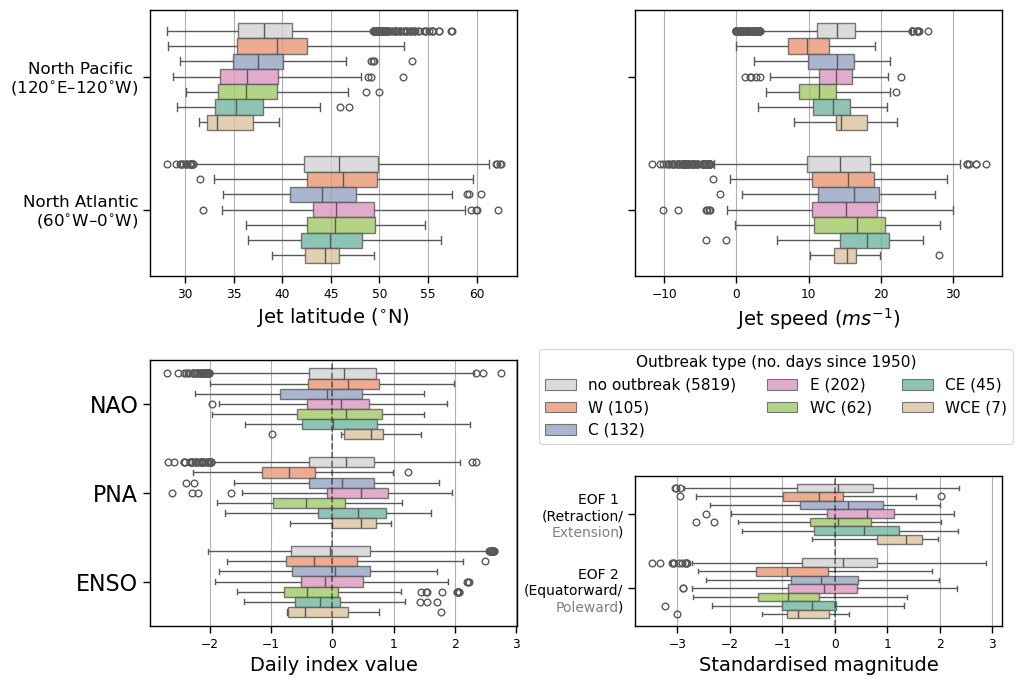

In [149]:
fig, axes = plt.subplot_mosaic([['a)', 'b)'], ['a)', 'b)'], ['a)', 'b)'], ['c)', 'd)'], ['c)', 'e)'], ['c)', 'e)']], figsize=(11, 8))
sns.set_context('paper')
sns.boxplot(x='Latitude', y='Region', hue='coldairevent', hue_order=hue_order, data=djf_jetlat_df_melt.loc[~(djf_jetlat_df_melt['Region'] == 'NAm')],\
                 boxprops=dict(alpha=.8), ax=axes['a)'], palette=color_pallete_to_use, legend=False)
sns.boxplot(x='Latitude', y='Region', hue='coldairevent', hue_order=hue_order, data=djf_jetspd_df_melt.loc[~(djf_jetspd_df_melt['Region'] == 'NAm')],\
                 boxprops=dict(alpha=.8), ax=axes['b)'], palette=color_pallete_to_use, legend=False)
box1 = sns.boxplot(x='Value', y='Indices', hue='coldairevent', hue_order=hue_order, data=djf_indices_melt.dropna(),\
                 ax=axes['c)'], boxprops=dict(alpha=.8), palette=color_pallete_to_use)

sns.boxplot(x='Value', y='Mode', hue='cold_air_event_stacked_names',\
            hue_order=hue_order,\
            boxprops=dict(alpha=.8), palette=color_pallete_to_use,\
            ax=axes['e)'], data=coldaircode_pcs_df_melt.dropna())

axes['c)'].set_ylabel("", size=12)
axes['a)'].set_ylabel("")
axes['e)'].set_ylabel("")
axes['a)'].set_yticks(axes['a)'].get_yticks(), axes['a)'].get_yticklabels(), size=16)

axes['a)'].set_yticklabels(["North Pacific \n(120$^{\circ}$E–120$^{\circ}$W)",\
                    "North Atlantic\n(60$^{\circ}$W–0$^{\circ}$W)"], size=12);
axes['b)'].set_ylabel("", size=15)
axes['b)'].set_yticklabels(["",""], size=12);

# axes['c)'].set_title("Climate patterns", size=19)
# axes['c)'].set_title("Climate patterns", size=19)
box1.get_legend().remove()
axes['d)'].remove()

handles, labels = box1.get_legend_handles_labels()
new_labels = []
for lab in labels:
    # new_lab = f"{lab[0]}-{lab[1]}-{lab[2]} ({djf_cao_names.to_dataframe()['cold_air_event_stacked_names'].value_counts()[lab]})"
    if lab == 'no outbreak':
        new_lab = f"{lab} ({djf_jetlat_df_melt['coldairevent'].value_counts()['no outbreak'] // 3})"
    else:
        new_lab = f"{lab} ({clustered_count_djf[lab]})"
    new_labels.append(new_lab)
axes['e)'].legend(handles, new_labels, title="Outbreak type (no. days since 1950)", title_fontsize=11, fontsize=11,\
            ncols=3, loc=0, bbox_to_anchor=(.55, 1.4, 0.5, 0.5))
axes['c)'].set_yticklabels(['NAO', 'PNA', 'ENSO'], size=16)
axes['c)'].axvline(linestyle='--', color='k', alpha=0.5)
axes['e)'].axvline(linestyle='--', color='k', alpha=0.5)

axes['e)'].set_yticklabels(['EOF 1 \n(Retraction/\n)', 'EOF 2 \n(Equatorward/\n)'], size=10)
axes['e)'].text(s='Extension', x=-5.4, y=0.31, size=10, c='grey')
axes['e)'].text(s='Poleward', x=-5.32, y=1.31, size=10, c='grey')

# axes['a)'].set_title("Jet latitude", size=19)
# axes['b)'].set_title("Jet speed", size=19)
axes['c)'].set_xlabel("Daily index value", size=14)
axes['e)'].set_xlabel("Standardised magnitude", size=14)

axes['a)'].set_xlabel("Jet latitude ($^{\circ}$N)", size=14)
axes['b)'].set_xlabel("Jet speed ($ms^{-1}$)", size=14)

for ax in axes:
    axes[ax].grid(axis='x')
fig.subplots_adjust(hspace=2.5, wspace=.32)
# fig.savefig("figures/jet_lat_EOF_djf_boxplot.png", bbox_inches='tight', dpi=300)
